In [1]:
import backtrader as bt
import backtrader.indicator as btind
import backtrader.feeds as btfeeds
import backtrader.analyzers as btanalyzers
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import argparse
import datetime
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings("ignore")
from tqdm import tqdm
from scipy.stats import rankdata
import matplotlib.pyplot as plt
import binance

In [2]:
#下載歷史資料
client = binance.Client()      #先將API實例化方便取用

#撰寫幣安爬蟲API
def data_download(symbol, symbol_class, interval, start_str) :

    if symbol_class == 'spot' :
        klines = client.get_historical_klines(symbol, interval, start_str)
    if symbol_class == 'future' :
        klines = client.futures_historical_klines(symbol, interval, start_str)
    data = pd.DataFrame(klines)
    data.columns = ['open_time', 'open', 'high', 'low', 'close',
    'volume', 'close_time', 'qav', 'num_trades',
    'taker_base_vol', 'taker_base_vol', 'ignore']    
    data.index = [datetime.datetime.fromtimestamp(x/1000.0) for x in data.close_time]
    data.index = data.index + datetime.timedelta(seconds = 0.001)
    data.reset_index(inplace=True)
    data.set_index('index',inplace=True)
    data = data[['open','high','low','close','volume']]
    data['open'] = data['open'].astype(float)
    data['high'] = data['high'].astype(float)
    data['low'] = data['low'].astype(float)
    data['close'] = data['close'].astype(float)
    data['volume'] = data['volume'].astype(float)
    data["openinterest"] = 0
    return data    

In [3]:
#下載歷史資料 data1=期貨 , data2=現貨
data1 = data_download('BTCUSDT','future','30m','2020-01-01')
data2 = data_download('BTCUSDT','spot','30m','2020-01-01')

In [4]:
#用pd函數intersection取出交集，在將交集放入原始資料，使兩者長度相等
idx = data1.index.intersection(data2.index)
data1 = data1.loc[idx]
data2 = data2.loc[idx]

In [213]:
#示範編寫參數方法，這裡只實現一個，其他我直接寫在策略類裡，也可以拉出來實現(我懶)
class difInd(bt.Indicator):
    lines = ('dif',)

    def next(self):
        self.lines.dif[0] = self.datas[0].close[0] - self.datas[1].close[0]

#策略類
class TestStrategy(bt.Strategy):
    #參數，之後優化可能會用到，這邊是默認
    params = (
        ('maperiod', 15),
        ('rolling_window', 130),
        ('tp_ratio', 20),
        ('sl_ratio', 6),
        ('longout', 80),
        ('shortout', 120),
        ('printout', False),

    )

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.lmt_1 = None
        self.lmt_2 = None
        

         # Add a MovingAverageSimple indicator
        self.dif = difInd(self.datas[0],self.datas[1])
        self.dif.plotinfo.plot = False
        self.spread_avg = (bt.ind.Highest(self.dif,period=self.params.rolling_window) - bt.ind.Lowest(self.dif,period=self.params.rolling_window))/2
        self.low = bt.ind.Lowest(self.datas[0].close,period = self.params.rolling_window)
        self.low.plotinfo.plot = False
        self.spot_hl = (bt.ind.Highest(self.datas[1].close,period = self.params.rolling_window) - self.low)/2
        self.spot_line = (bt.ind.Highest(self.datas[1].close,period = self.params.rolling_window) + self.low)/2
        self.datas[1].plotinfo.plot = False
        self.upper_band = self.spot_line + 0.3*(self.spot_hl+self.spread_avg)
        self.lower_band = self.spot_line - 0.2*(self.spot_hl+self.spread_avg)
        self.lowout = bt.ind.Lowest(self.datas[0].low,period=self.params.longout)
        self.lowout.plotinfo.plot = True
        self.lowout.plotinfo.subplot = False
        self.highout = bt.ind.Highest(self.datas[0].high,period =self.params.shortout)
        self.highout.plotinfo.plot = True
        self.highout.plotinfo.subplot = False
        

    def start(self):
        if self.p.printout:
            txtfields = list()
            txtfields.append('Len')
            txtfields.append('Datetime')
            txtfields.append('Open')
            txtfields.append('High')
            txtfields.append('Low')
            txtfields.append('Close')
            txtfields.append('Volume')
            txtfields.append('OpenInterest')
            print(','.join(txtfields))


    def notify_order(self, order):
        type = "Buy" if order.isbuy() else "Sell"
        
        if order.status in [order.Submitted,order.Accepted]:
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:

            if order.isbuy():
                self.buyprice = order.executed.price
                if self.position:
                    self.lmt_1 = self.sell(exectype= bt.Order.Limit, price = self.buyprice*(1+0.01*self.params.tp_ratio))
                    self.sell(exectype = bt.Order.Stop, price = self.buyprice*(1-0.01*self.params.sl_ratio),oco = self.lmt_1)
                    # self.sell(exectype = bt.Order.StopTrail, price = self.lowout[0],oco = self.lmt_1)

            elif order.issell():
                self.sellprice = order.executed.price
                if self.position:
                    self.lmt_2 = self.buy(exectype=bt.Order.Limit, price = self.sellprice*(1-0.01*self.params.tp_ratio))
                    self.buy(exectype=bt.Order.Stop, price= self.sellprice*(1+0.01*self.params.sl_ratio),oco = self.lmt_2)
                    # self.buy(exectype=bt.Order.StopTrail, price= self.highout[0],oco= self.lmt_2)
                
            self.bar_executed = len(self)

        
       

        # Write down: no pending order
        self.order = None


    def notify_trade(self, trade):
        if not trade.isclosed:
            return

       
    def next(self):
       
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.p.printout:
            # Print only 1st data ... is just a check that things are running
            txtfields = list()
            txtfields.append('%04d' % len(self))
            txtfields.append(self.data.datetime.datetime(0).isoformat())
            txtfields.append('%.2f' % self.datas[0].open[0])
            txtfields.append('%.2f' % self.datas[0].high[0])
            txtfields.append('%.2f' % self.datas[0].low[0])
            txtfields.append('%.2f' % self.datas[0].close[0])
            txtfields.append('%.2f' % self.datas[0].volume[0])
            txtfields.append('%.2f' % self.datas[0].openinterest[0])
            print(','.join(txtfields))



        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            if (self.dataclose[-1] < self.upper_band[0]) & (self.dataclose[0] > self.upper_band[0]) & (self.dataclose[0]*0.01*4 > self.spot_hl[0]):
                # BUY, BUY, BUY!!! (with all possible default parameters)
                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy(exectype= bt.Order.Limit,price = self.dataclose[0])


            elif (self.dataclose[-1] > self.lower_band[0]) & (self.dataclose[0] < self.lower_band[0]) & (self.dataclose[0]*0.01*4 > self.spot_hl[0]):
                self.order = self.sell(exectype= bt.Order.Limit,price = self.dataclose[0])

        if self.position.size >0:
            # print('lowout',self.lowout[0])
            if self.dataclose[0] <= self.lowout[0]:
                self.sell(oco = self.lmt_1)

        if self.position.size <0:
            # print('highout',self.highout[0])
            if self.dataclose[0] >= self.highout[0]:
                self.buy(oco = self.lmt_2)



In [221]:
def parse_args(args=None):

    parser = argparse.ArgumentParser(
        formatter_class=argparse.ArgumentDefaultsHelpFormatter,
        description='Sample for pivot point and cross plotting')

    parser.add_argument('--maperiod', required=False, action='store',
                        type = float, default= 15, choices=range(1,300),
                        help=('Set maperiod'))

    parser.add_argument('--rolling_window', required=False, action='store',
                        type = float, default= 130, choices=range(1,300),
                        help=('Set rolling_window'))

    parser.add_argument('--tp_ratio', required=False, action='store',
                        type = float, default= 20, choices=range(1,300),
                        help=('Set tp_ratio'))

    parser.add_argument('--sl_ratio', required=False, action='store',
                        type = float, default= 6, choices=range(1,300),
                        help=('Set sl_ratio'))

    parser.add_argument('--longout', required=False, action='store',
                        type = float, default= 80, choices=range(1,300),
                        help=('Set longout'))

    parser.add_argument('--shortout', required=False, action='store',
                        type = float, default= 120, choices=range(1,300),
                        help=('Set shortout'))

    parser.add_argument('--printout', required=False, action='store_true',
                        default= False,
                        help=('Print data lines'))

    parser.add_argument('--cash', required=False, action='store',
                        type=float, default=100000.0,
                        help=('Cash to start with'))

    parser.add_argument('--plot', required=False, action='store_true',
                        default= False, 
                        help=('Plot the result'))

    parser.add_argument('--plot-style', required=False, action='store',
                        default='bar', choices=['bar', 'candle', 'line'],
                        help=('Plot style'))

    parser.add_argument('--use-pyfolio', required=False, action='store_true',
                        default= False,
                        help=('Do pyfolio things'))

    if args == None:
        argss ,unknown = parser.parse_known_args()
    else:
        argss = parser.parse_args(args)
    return argss


In [230]:
def runstrat(args):
    args = parse_args(args)

    cerebro = bt.Cerebro()
    cerebro.broker.set_cash(args.cash)

    params = dict(
            fromdate = datetime.datetime(2020,1,1), # 回测开始时间
            todate = datetime.datetime(2022,11,8),  # 回测结束时间
            timeframe = bt.TimeFrame.Minutes,
            compression = 1,
            dtformat=('%Y-%m-%d %H:%M:%S'), # 日期和时间格式
            tmformat=('%H:%M:%S'), # 时间格式
            datetime=0, # 下面几行是导入的数据，要和传入的数据列进行一一对应，以这个参数为准
            high=2,
            low=3,
            open=1,
            close=4,
            volume=5,
            openinterest=6)

    # Create a Data Feed
    datafeed1 = bt.feeds.PandasDirectData(dataname = data1, **params)
    datafeed2 = bt.feeds.PandasDirectData(dataname = data2, **params)

    # Add the Data Feed to Cerebro
    cerebro.adddata(datafeed1)
    cerebro.adddata(datafeed2)

    cerebro.broker.setcash(args.cash)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=1)

    # 0.1% ... divide by 100 to remove the %
    cerebro.broker.setcommission(commission=0)

    cerebro.addstrategy(TestStrategy, printout=args.printout)

    if  args.use_pyfolio:
        cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

    results = cerebro.run()

     
    if  args.use_pyfolio:
        strat = results[0]
        pyfoliozer = strat.analyzers.getbyname('pyfolio')

        returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
        if args.printout:
            print('-- RETURNS')
            print(returns)
            print('-- POSITIONS')
            print(positions)
            print('-- TRANSACTIONS')
            print(transactions)
            print('-- GROSS LEVERAGE')
            print(gross_lev)


        import pyfolio as pf
        pf.create_full_tear_sheet(
            returns,
            positions=positions,
            transactions=transactions,
            live_start_date='2022-01-01',
            )

    if  args.plot:
        plt.rcParams['figure.figsize'] = 30, 20  # that's default image size for this interactive session
        cerebro.plot(style=args.plot_style)

    return args
    

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,20.93,2021-04-13,2021-06-14,2022-01-10,195
1,17.85,2022-02-10,2022-10-13,NaT,NaN
2,8.45,2021-01-27,2021-02-02,2021-02-17,16
3,5.27,2022-01-12,2022-02-03,2022-02-10,22
4,4.21,2020-11-25,2020-12-24,2020-12-30,26


<IPython.core.display.Javascript object>

Stress Events,mean,min,max
New Normal,0.03%,-5.94%,8.10%


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Top 10 long positions of all time,max
sid,
,45.27%


Top 10 short positions of all time,max
sid,
,-129.79%


Top 10 positions of all time,max
sid,
,129.79%
Data1,0.00%


<IPython.core.display.Javascript object>

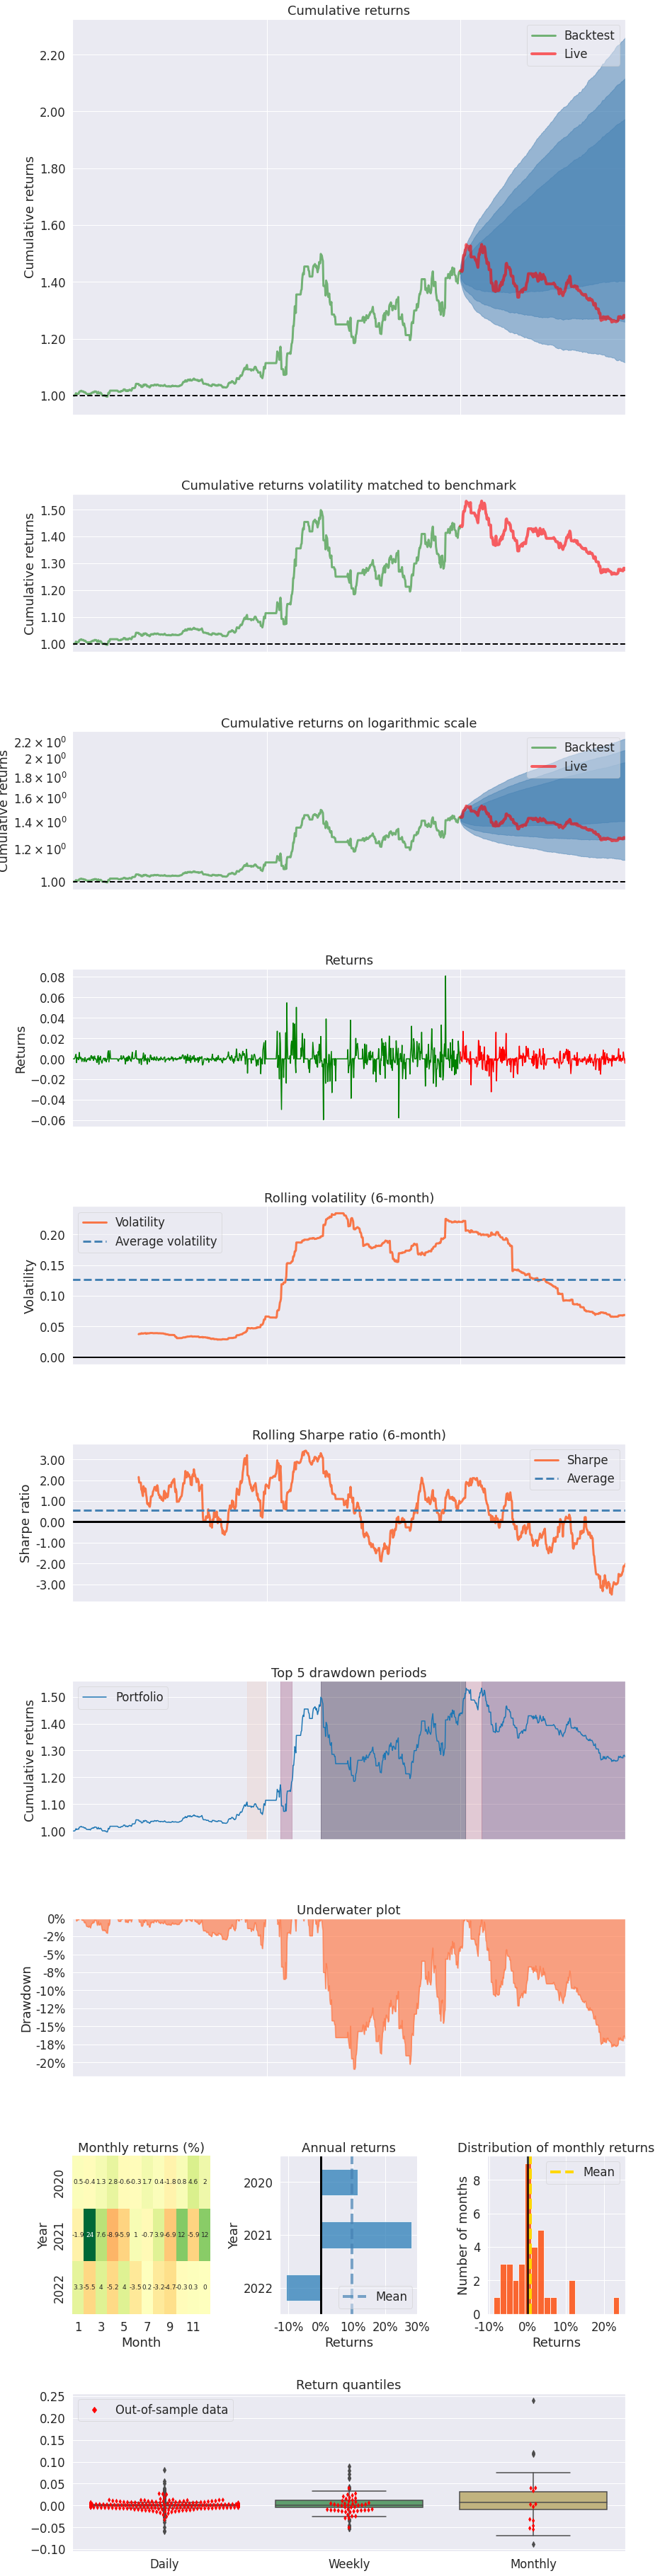

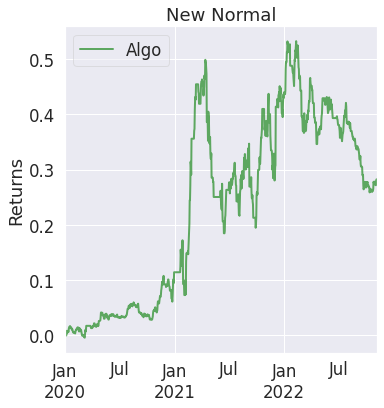

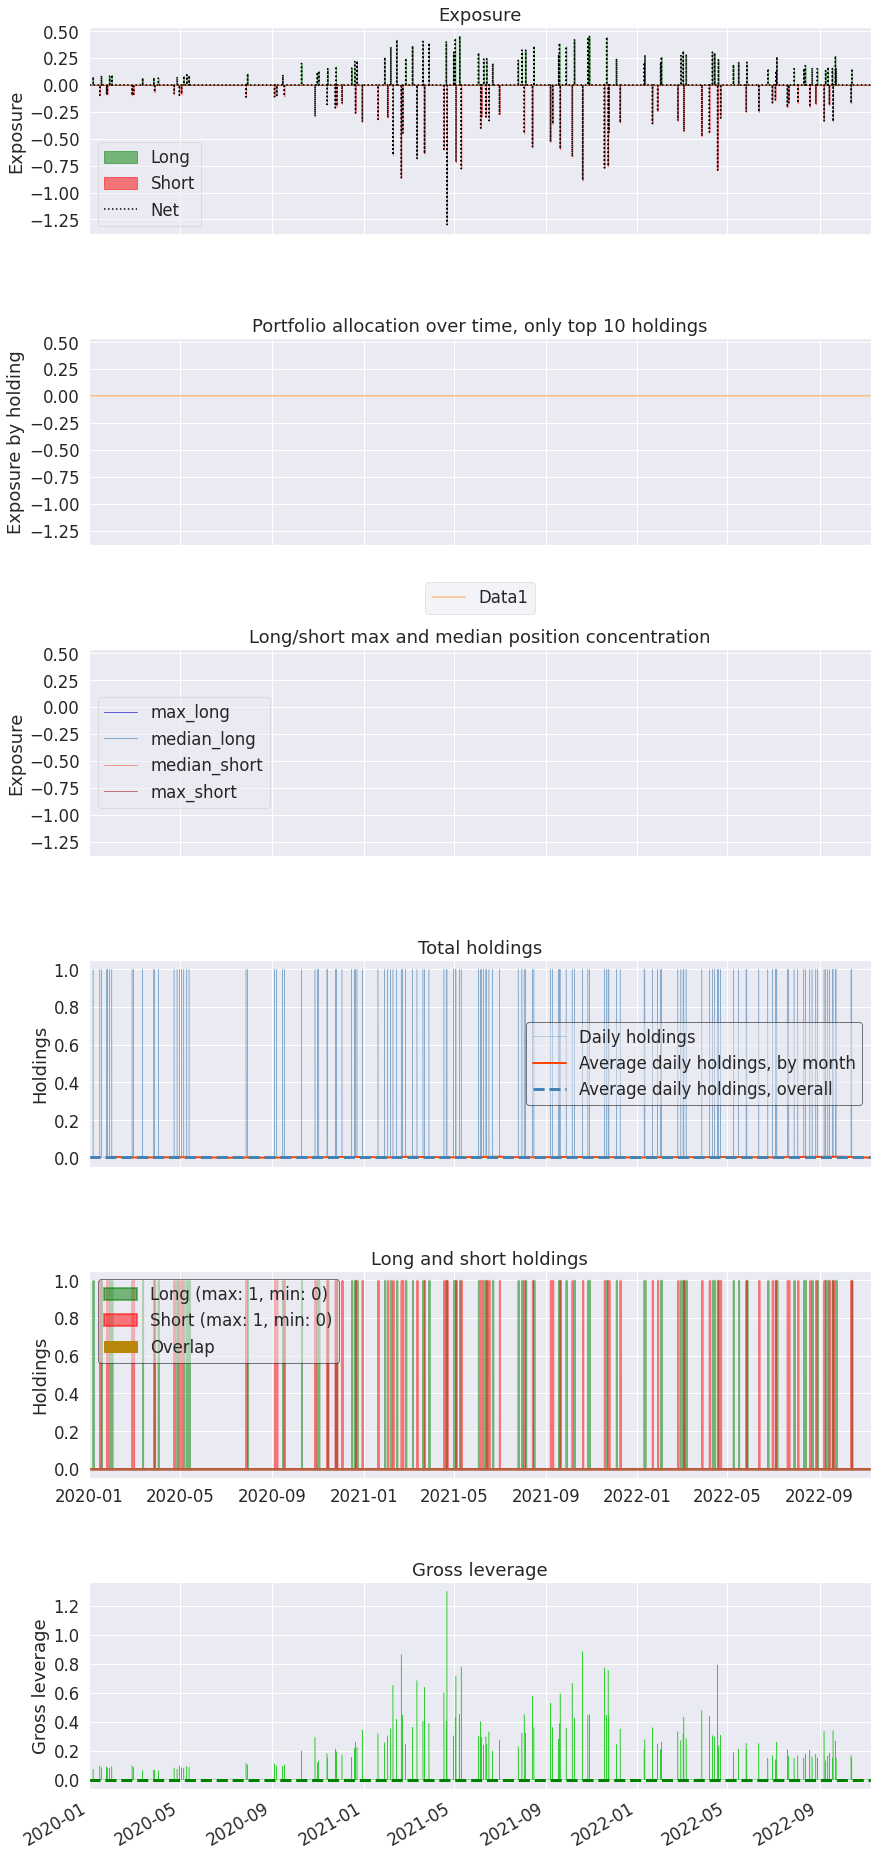

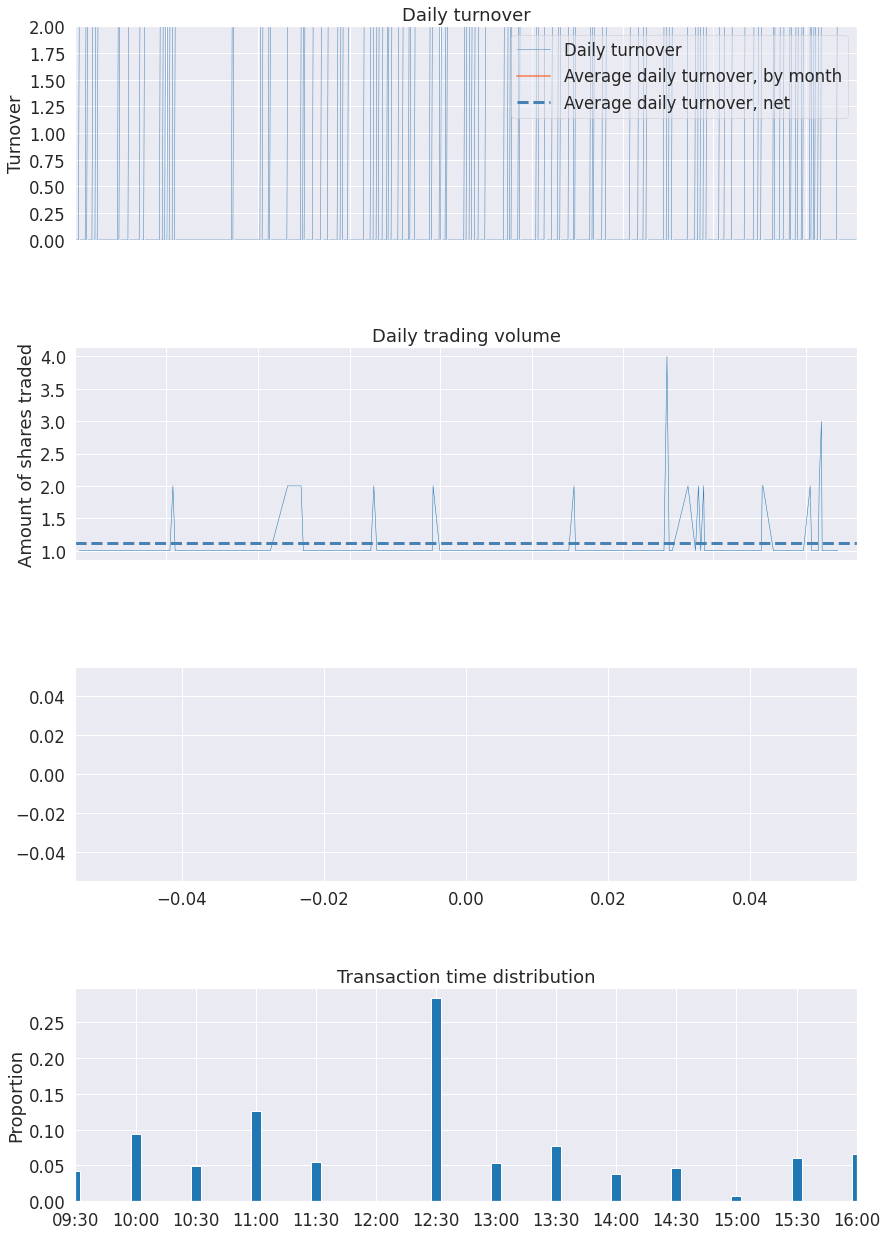

In [234]:
args = runstrat(['--use-pyfolio'])

<IPython.core.display.Javascript object>

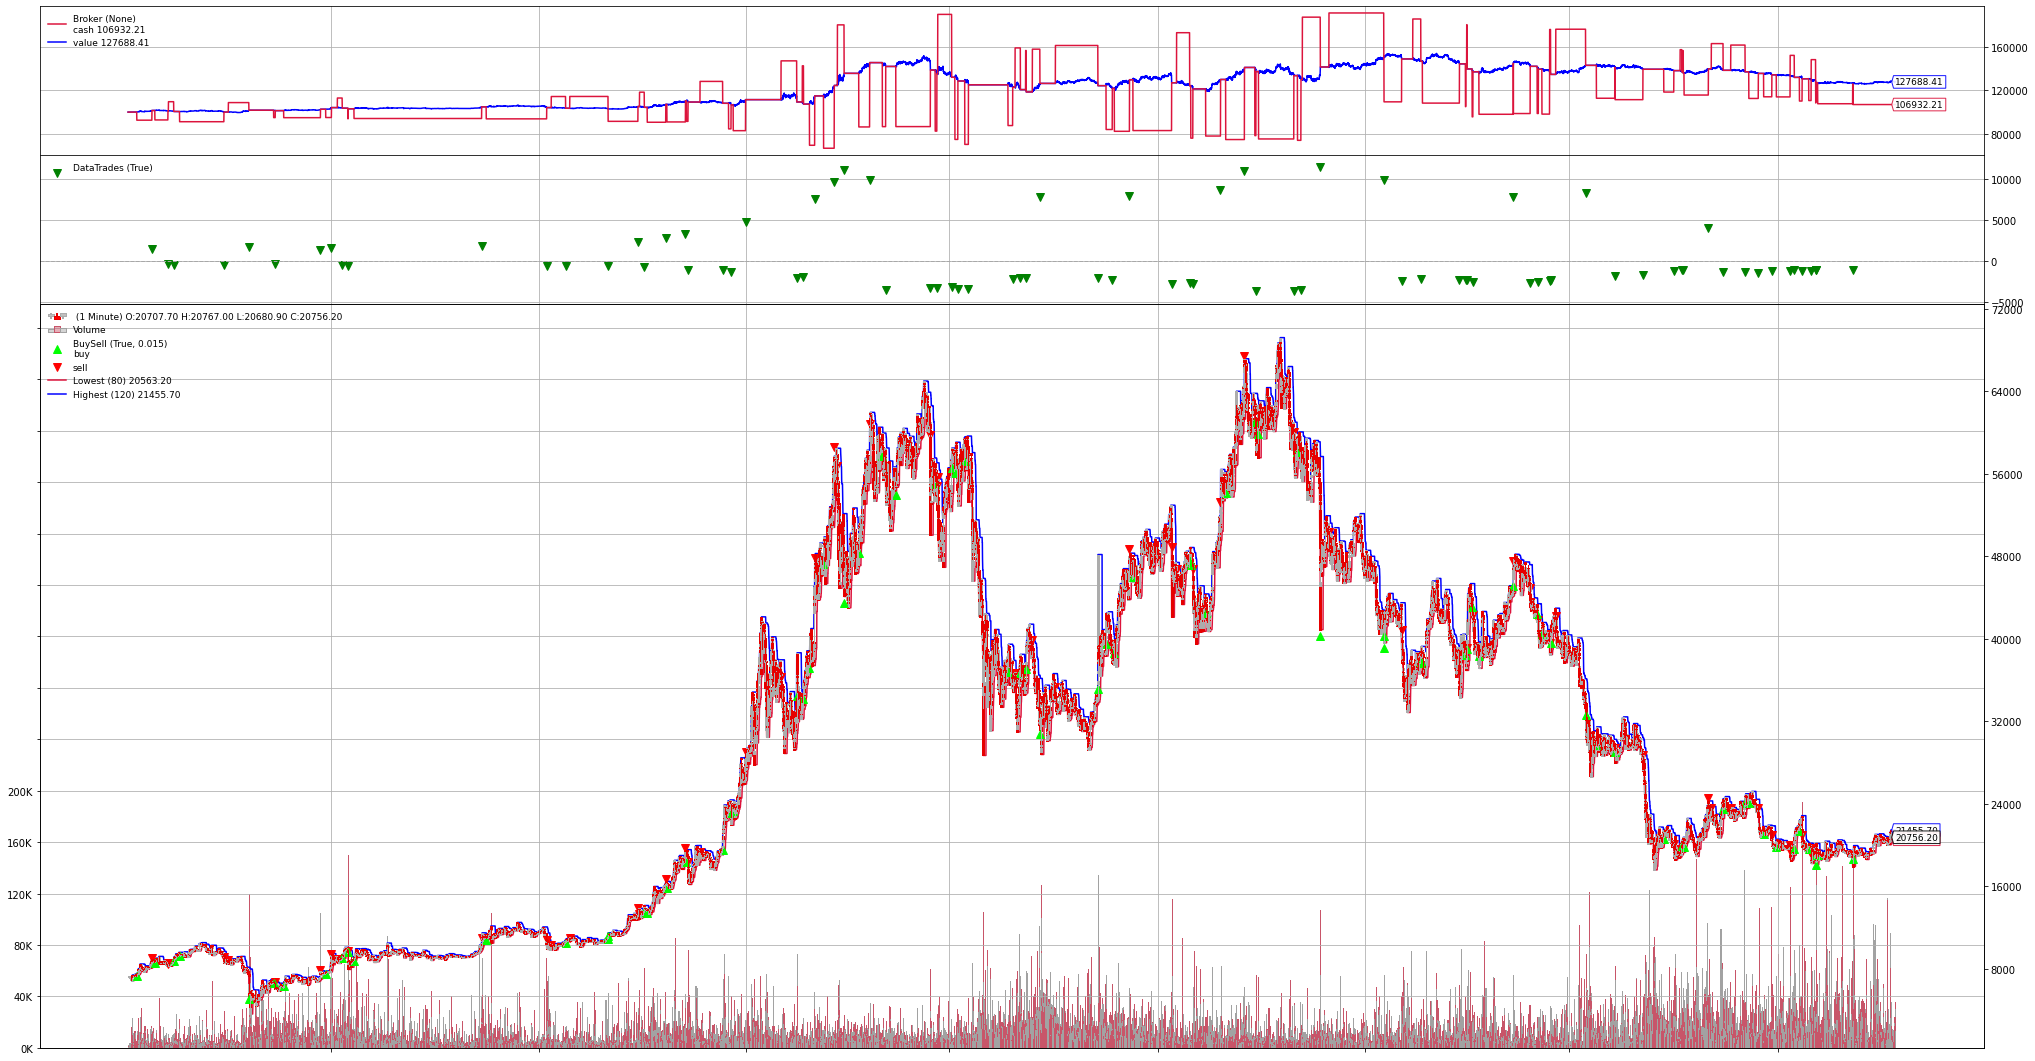

In [232]:
args = runstrat(['--plot','--plot-style','candle'])

In [233]:
args

Namespace(maperiod=15, rolling_window=130, tp_ratio=20, sl_ratio=6, longout=80, shortout=120, printout=False, cash=100000.0, plot=True, plot_style='candle', use_pyfolio=False)